In [19]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Taxi-v3', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self,**kwargs):
        self.step_n = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        self.step_n += 1
        if self.step_n >= 1000:
            terminated = True
        return state, reward, terminated, truncated, info


env = MyWrapper()

env.reset()

(81, {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)})

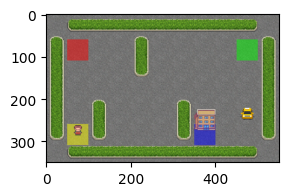

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [5]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state, probs = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info  = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', terminated)
    print('probs=',probs)


test_env()

env.observation_space= Discrete(500)
env.action_space= Discrete(6)
state= 446
action= 3
next_state= 426
reward= -1
done= False
probs= {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}


In [29]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env

#初始化模型 
model = DQN(
    policy='MlpPolicy',
    env=make_vec_env(MyWrapper, n_envs=8),  #使用N个环境同时训练
    learning_rate=1e-3,
    buffer_size=1000,  #最多积累N步最新的数据,旧的删除 experience replay
    learning_starts=100,  #积累了N步的数据以后再开始训练
    batch_size=64,  #每次采样N步
    tau=0.98,  #软更新的比例,1就是硬更新
    gamma=0.99,
    train_freq=(1, 'step'),  #训练的频率
    target_update_interval=500,  #target网络更新的频率
    policy_kwargs={},  #网络参数
    exploration_fraction=0.7, 
    exploration_initial_eps=1.0, 
    exploration_final_eps=0.1, 
    max_grad_norm=10, 
    stats_window_size=100, # Window size for the rollout logging, mean episode length, and mean reward
    tensorboard_log=None, 
    seed=None, 
    _init_setup_model=True,
    verbose=1,
    device='cuda')

model

Using cuda device


In [7]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env, n_eval_episodes=20, deterministic=False)

c:\Users\13306\anaconda3\envs\SB3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-200.0, 0.0)

In [30]:
# #训练N局游戏
model.learn(30_0000, progress_bar=True)

# #保存模型
model.save('save/3.DQN.Taxi')

c:\Users\13306\anaconda3\envs\SB3\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter
support
  warnings.warn('install "ipywidgets" for Jupyter support')

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 182      |
|    ep_rew_mean      | -732     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2534     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.099    |
|    n_updates        | 187      |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 182      |
|    ep_rew_mean     | -732     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2532     |
|    time_elapsed    | 0        |
|    total_timesteps | 1600     |
---------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 191      |
|    ep_rew_mean      | -753  

In [31]:
#加载模型
model = DQN.load('save/3.DQN.Taxi')

evaluate_policy(model, env, n_eval_episodes=20, deterministic=True)

c:\Users\13306\anaconda3\envs\SB3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(7.6, 2.596150997149434)

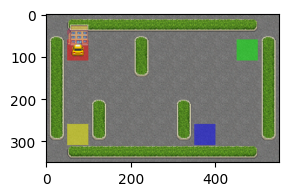

4 17 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 20]


In [45]:
from IPython import display
import random


def test():
    state,_ = env.reset()
    reward_sum = []
    terminated = False
    while not terminated:
        action, _ = model.predict(state,deterministic=True)
        action = action.item()
        state, reward, terminated, truncated, info = env.step(action)
        reward_sum.append(reward)

        if len(reward_sum) % 1 == 0:
            display.clear_output(wait=True)
            show()

    print(sum(reward_sum), len(reward_sum), reward_sum)


test()